# Weather Data Prediction 
### This notebook uses a Ridge regression model to predict high and low temperatures of data from May 2023 to July 2024.

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
df = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration and Cleaning

In [2]:
df.isnull().sum()

location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [3]:
# Drop Columns of No Interest
df = df.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

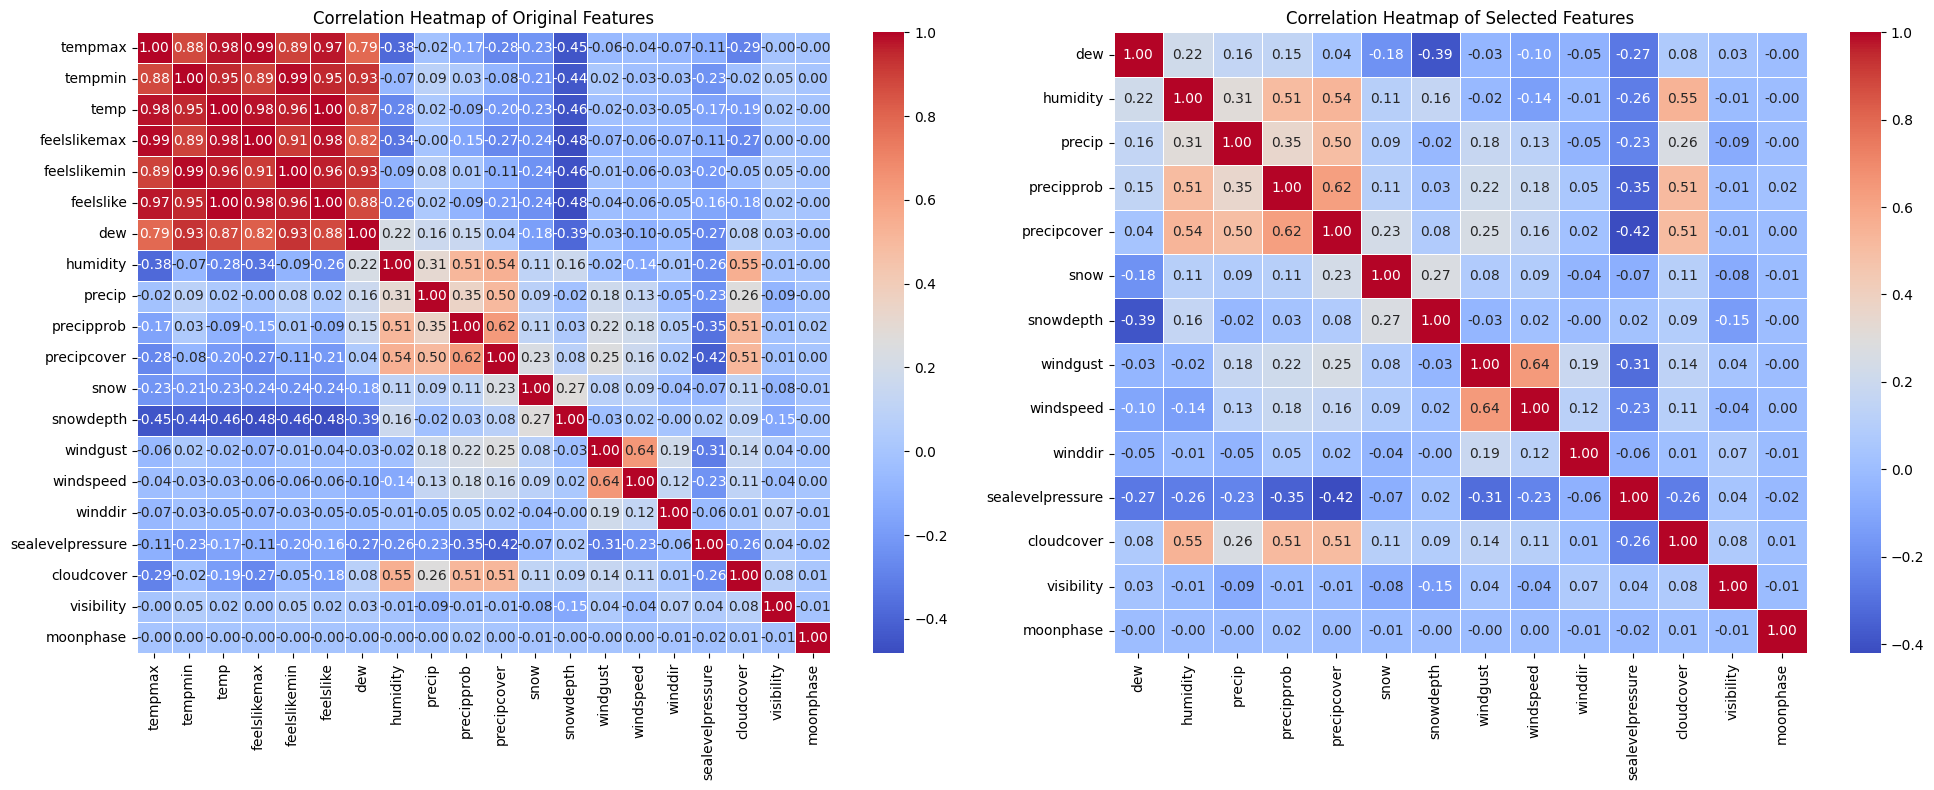

In [4]:
# Select only numerical columns from the DataFrame
features = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for original features
corr_matrix = features.corr()

# Drop highly correlated features
selected_features = features[['dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

# Calculate the correlation matrix for selected features
corr_matrix_selected = selected_features.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the heatmap for original features
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of Original Features')

# Plot the heatmap for selected features
sns.heatmap(corr_matrix_selected, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of Selected Features')

# Show the plot
plt.tight_layout()
plt.show()

### Addressing Multicollinearity - VIF Test Results 
Feature VIF
- dew  1.510584
- humidity  2.085587
- precip  1.400609
- precipprob  1.943016
- precipcover  2.514365
- snow  1.156531
- snowdepth  1.369926
- windgust  1.874062
- windspeed  1.856105
- winddir  1.057459
- sealevelpressure  1.445325
- cloudcover  1.695674
- visibility  1.066129
- moonphase  1.001601

## Fit linear model and test linearity in data

Likelihood Ratio Test:
- LR Statistic: 773.5384528999584
- p-value: 3.818608282633119e-155
- The polynomial model significantly improves the fit, indicating non-linearity.

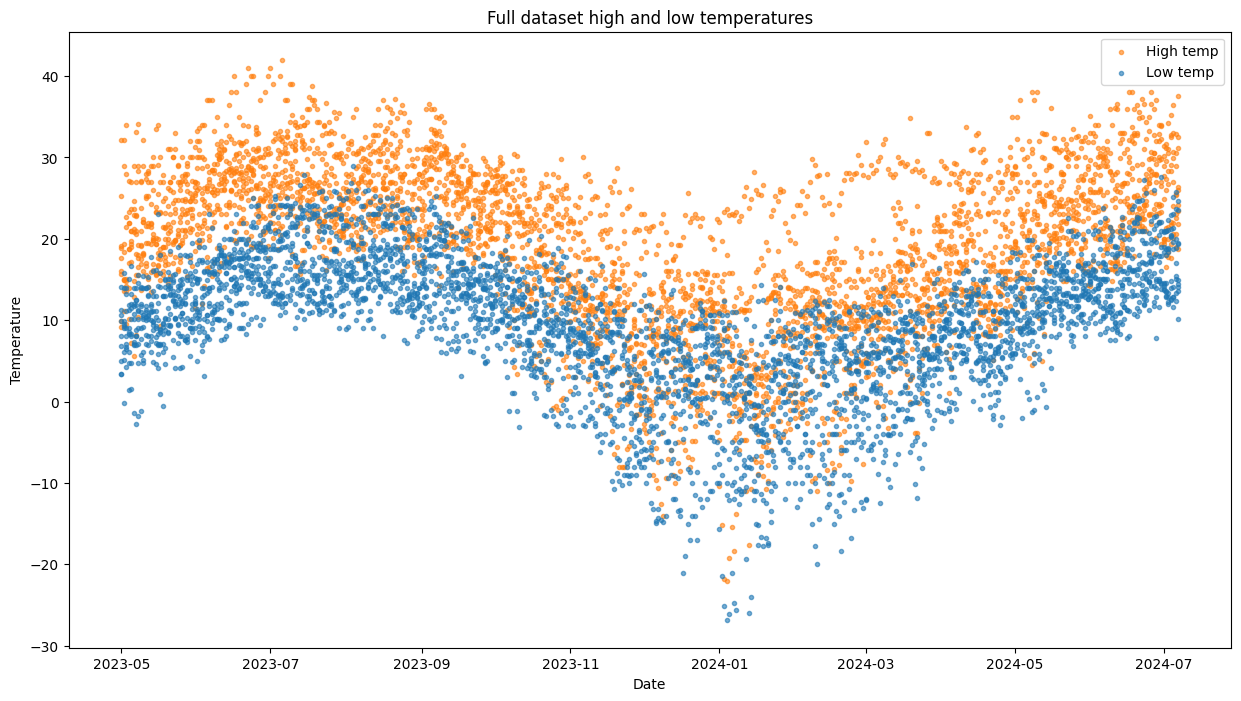

In [5]:
# Split data
# Plot the tempmax and tempmin values
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(df.index, df['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(df.index, df['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Train/Validate/Test Split

In [6]:
# Split training and testing data by dates
train = df.loc[df.index < '2024-03-01']
validate = df.loc[(df.index >= '2024-03-01') & (df.index < '2024-04-13')]
test = df.loc[df.index >= '2024-04-13']

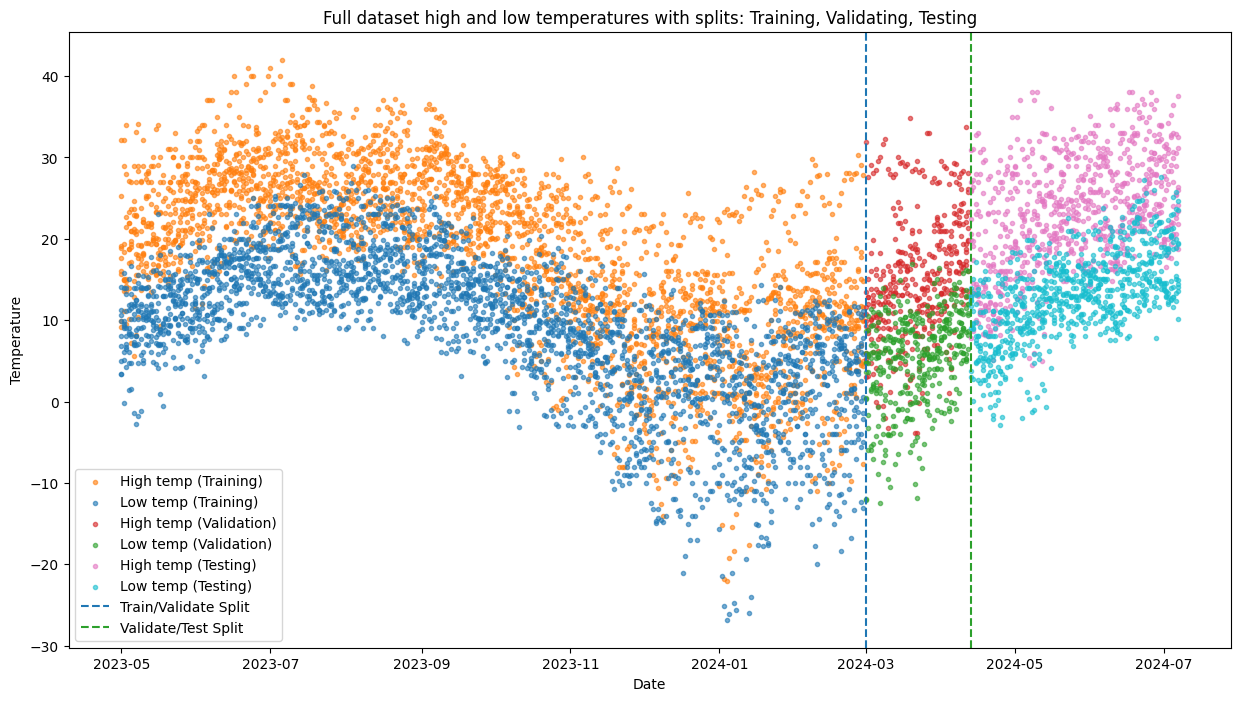

In [7]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Feature Selection

In [23]:
# Define features for TempMax and target
X_max = ['dew', 'precipcover', 'cloudcover']
y_max = 'tempmax'

# Define features for TempMin and target
X_min = ['dew', 'precipprob', 'precipcover', 'winddir', 'cloudcover', 'visibility']
y_min = 'tempmin'

## Visualize Feature/Target Relationship

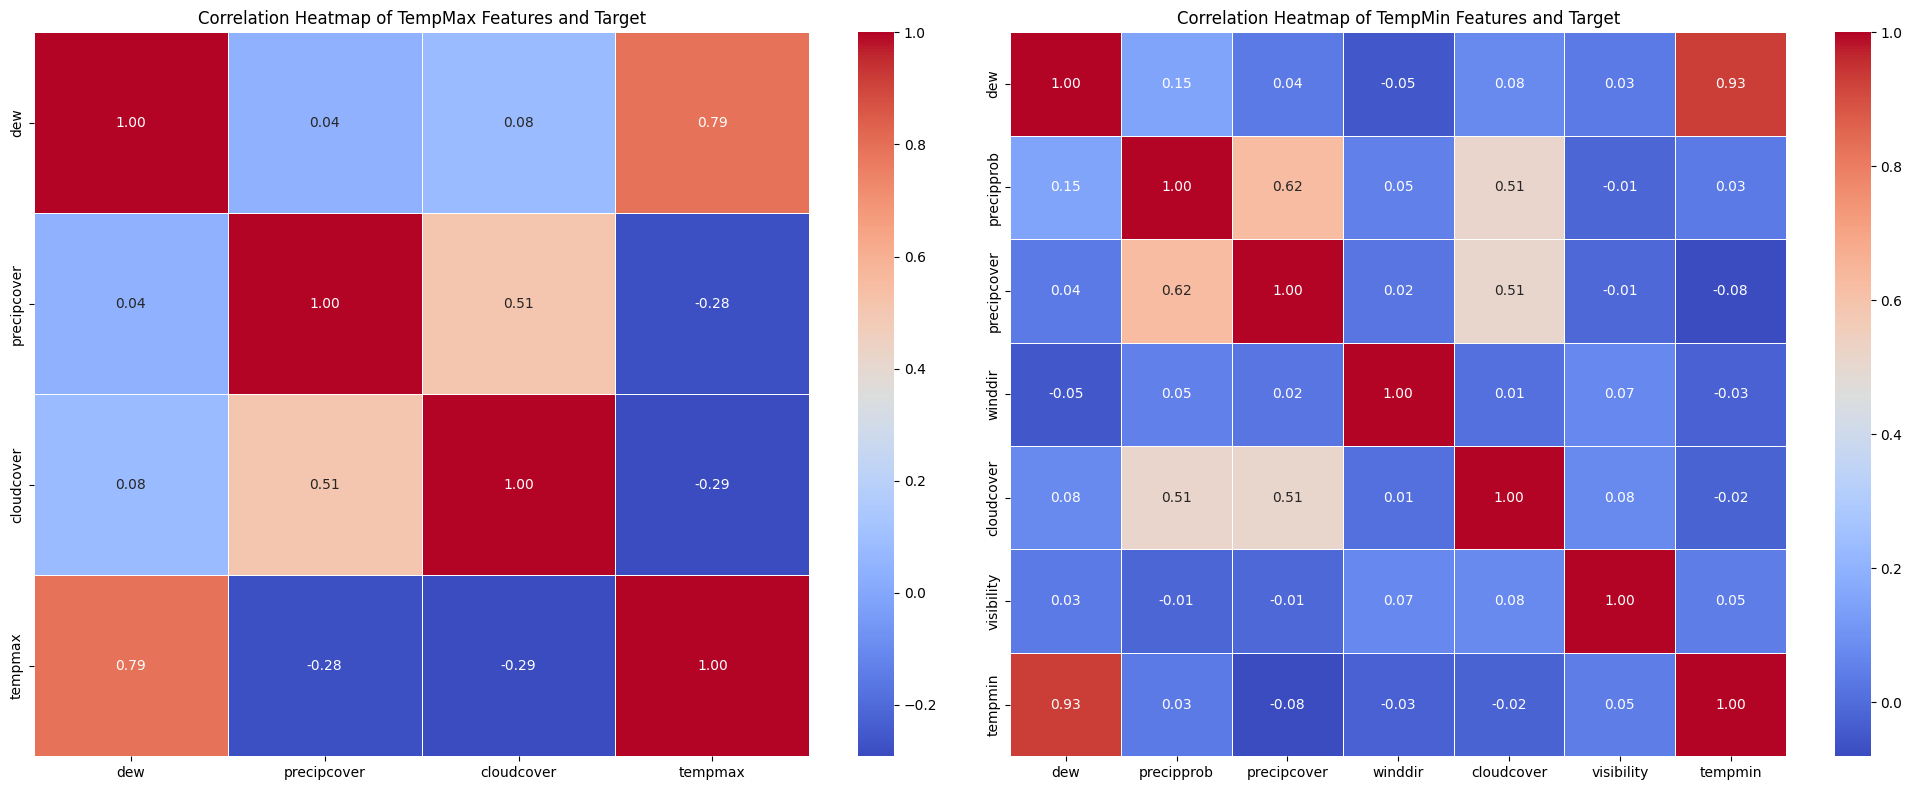

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the features and target for TempMax and TempMin
data_max = df[X_max + [y_max]]
corr_matrix_max = data_max.corr()

# Select the features and target for TempMax and TempMin
data_min = df[X_min + [y_min]]
corr_matrix_min = data_min.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot heatmap for TempMax
sns.heatmap(corr_matrix_max, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of TempMax Features and Target')

# Plot heatmap for TempMin
sns.heatmap(corr_matrix_min, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of TempMin Features and Target')

plt.tight_layout()
plt.show()



## Create Model

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit()

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Residual analysis
    residuals = y_train - y_train_pred

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted for {model_name}')

    plt.subplot(1, 2, 2)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Autocorrelation
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.title(f'Autocorrelation of Residuals for {model_name}')
    plt.show()


Model Summary for TempMax:
                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     4514.
Date:                Thu, 25 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:44:49   Log-Likelihood:                -7885.4
No. Observations:                2743   AIC:                         1.578e+04
Df Residuals:                    2739   BIC:                         1.580e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.4139 

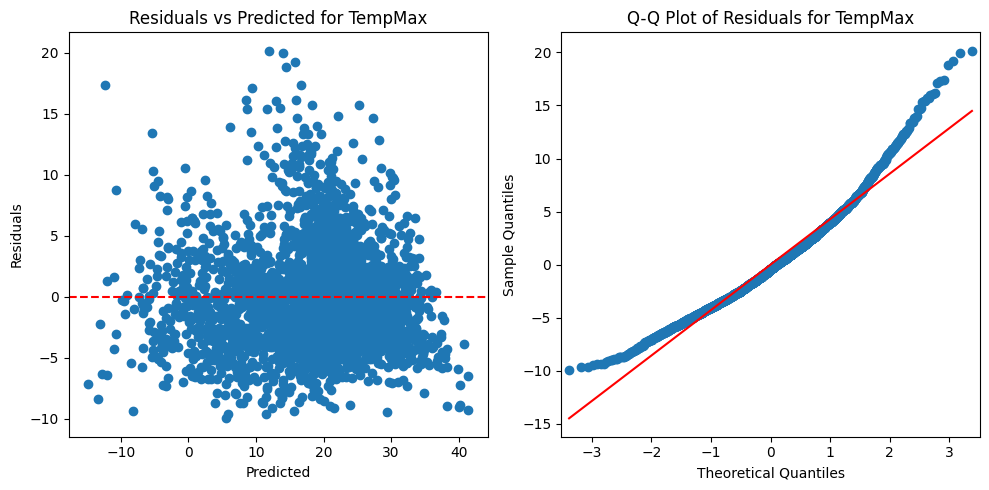

VIF for TempMax:
        feature       VIF
0          dew  1.526086
1  precipcover  1.786938
2   cloudcover  2.400583


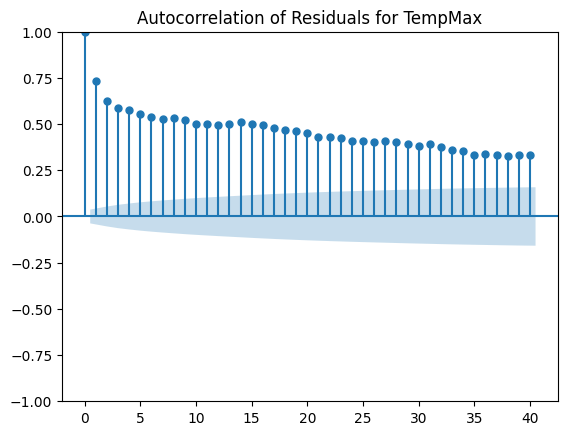

Model Summary for TempMin:
                            OLS Regression Results                            
Dep. Variable:                tempmin   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     4519.
Date:                Thu, 25 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:44:49   Log-Likelihood:                -6598.7
No. Observations:                2743   AIC:                         1.321e+04
Df Residuals:                    2736   BIC:                         1.325e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7927 

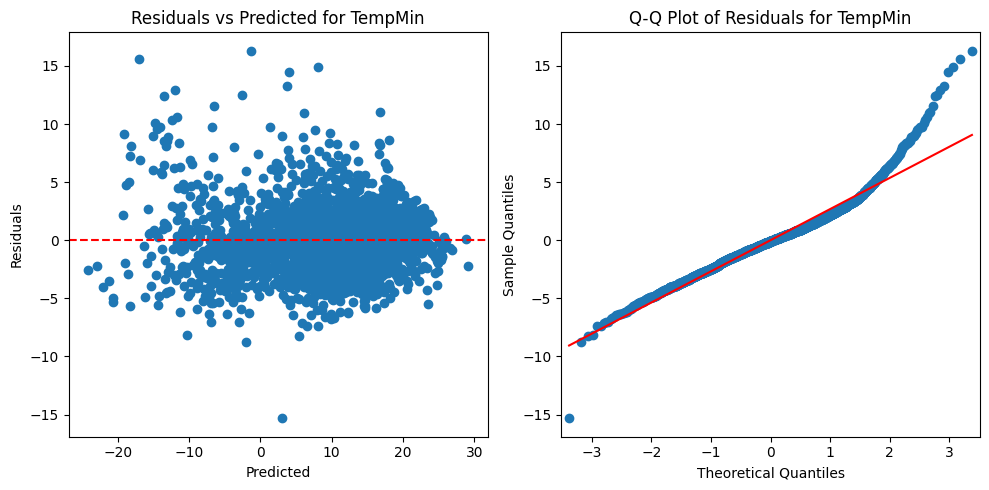

VIF for TempMin:
        feature       VIF
0          dew  1.651791
1   precipprob  3.663765
2  precipcover  2.397205
3      winddir  3.435949
4   cloudcover  5.925271
5   visibility  3.613494


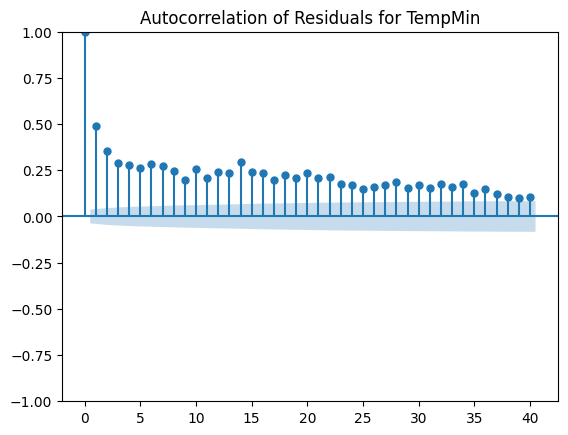

In [27]:
# Training set TempMax and TempMin
X_train_max = train[X_max]
y_train_max = train[y_max]
X_train_min = train[X_min]
y_train_min = train[y_min]

# Validation set TempMax and TempMin
X_val_max = validate[X_max]
y_val_max = validate[y_max]
X_val_min = validate[X_min]
y_val_min = validate[y_min]

# Testing set TempMax and TempMin
X_test_max = test[X_max]
y_test_max = test[y_max]
X_test_min = test[X_min]
y_test_min = test[y_min]


# Initialize and train the models on training data
model_max = LinearRegression()
model_max.fit(X_train_max, y_train_max)
model_min = LinearRegression()
model_min.fit(X_train_min, y_train_min)

# Evaluate the models
evaluate_model(X_train_max, y_train_max, X_val_max, y_val_max, 'TempMax')
evaluate_model(X_train_min, y_train_min, X_val_min, y_val_min, 'TempMin')

In [12]:
# Evaluate the model using cross-validation on the training set - TempMax
cv_scores_max = cross_val_score(model_max, X_train_max, y_train_max, cv=5)
print(f"Cross-Validation Scores Features - TempMax: {cv_scores_max}")
print(f"Mean CV Score Features - TempMax: {cv_scores_max.mean()}\n")

# Evaluate the model using cross-validation on the training set - TempMin
cv_scores_min = cross_val_score(model_min, X_train_min, y_train_min, cv=5)
print(f"Cross-Validation Scores Features - TempMin: {cv_scores_min}")
print(f"Mean CV Score Features - TempMin: {cv_scores_min.mean()}\n")

# Validate on the validation set - TempMax
y_val_pred_max = model_max.predict(X_val_max)
val_r2_score_max = r2_score(y_val_max, y_val_pred_max)
print(f"R² Score on Validation Set - TempMax: {val_r2_score_max}")

# Validate on the validation set - TempMin
y_val_pred_min = model_min.predict(X_val_min)
val_r2_score_min = r2_score(y_val_min, y_val_pred_min)
print(f"R² Score on Validation Set - TempMin: {val_r2_score_min}\n")



Cross-Validation Scores Features - TempMax: [0.75316757 0.60334724 0.85177468 0.89452537 0.8390775 ]
Mean CV Score Features - TempMax: 0.7883784703464541

Cross-Validation Scores Features - TempMin: [0.85580922 0.8361167  0.90312878 0.93491477 0.89622175]
Mean CV Score Features - TempMin: 0.8852382458550299

R² Score on Validation Set - TempMax: 0.20477064661945454
R² Score on Validation Set - TempMin: 0.5782543864462842



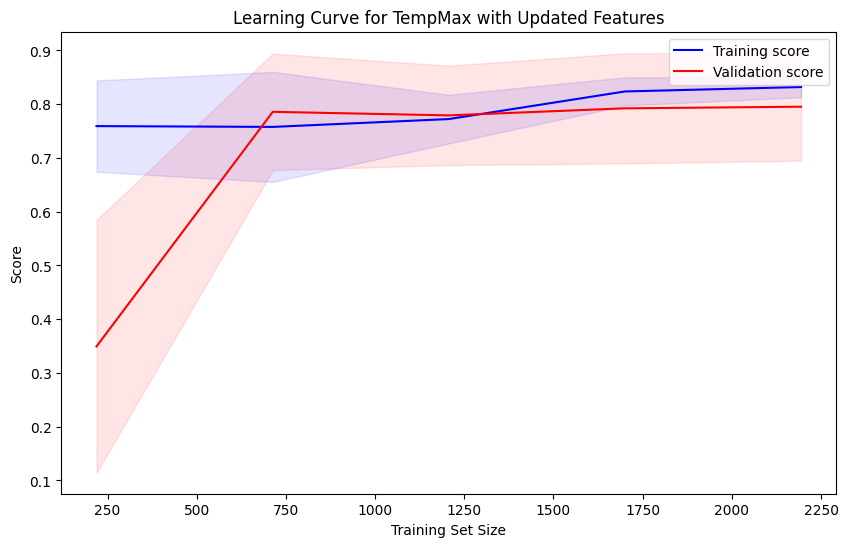

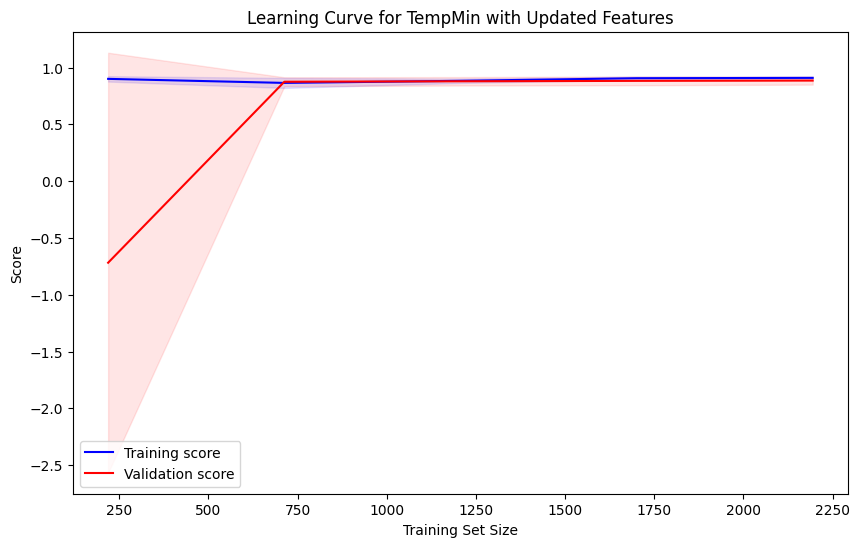

In [29]:
# Plot learning curve for the final model
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_std = val_scores.std(axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.plot(train_sizes, val_mean, label='Validation score', color='red')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot learning curve for TempMax with the final model
plot_learning_curve(model_max, X_train_max, y_train_max, 'Learning Curve for TempMax with Updated Features')

# Plot learning curve for TempMin with the final model
plot_learning_curve(model_min, X_train_min, y_train_min, 'Learning Curve for TempMin with Updated Features')

## Error Analysis

In [14]:
# Calculate residuals for TempMax
residuals_max = y_val_max - y_val_pred_max

# Calculate residuals for TempMin
residuals_min = y_val_min - y_val_pred_min


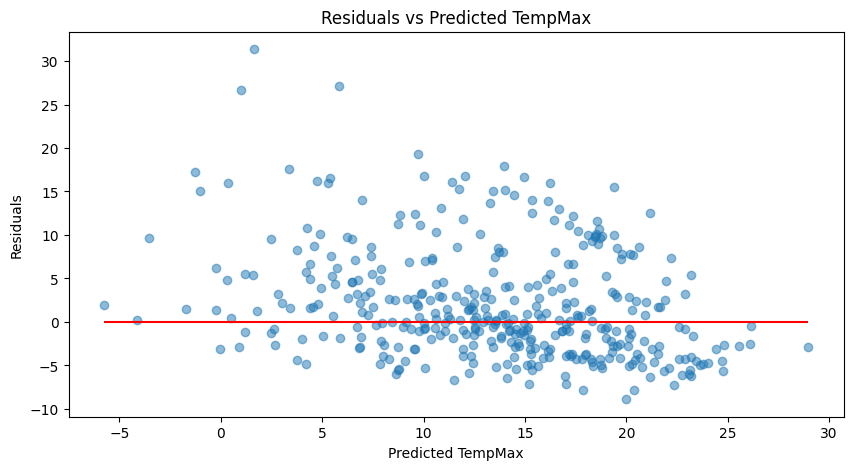

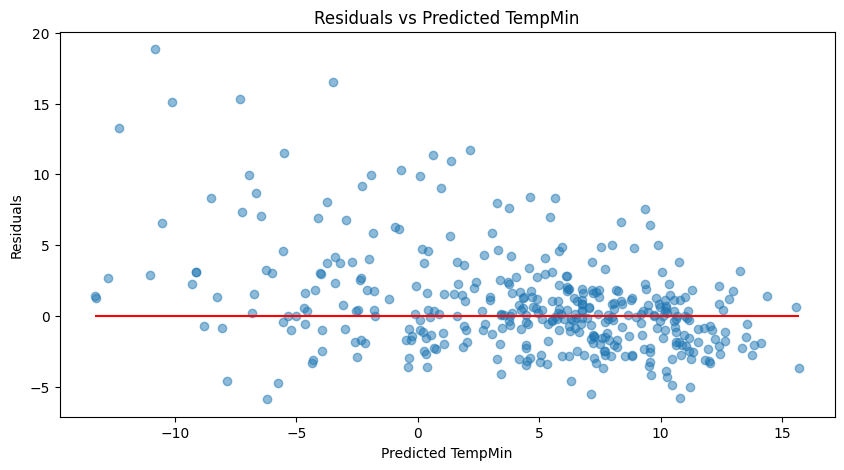

In [15]:
import matplotlib.pyplot as plt

# Plot residuals for TempMax
plt.figure(figsize=(10, 5))
plt.scatter(y_val_pred_max, residuals_max, alpha=0.5)
plt.hlines(y=0, xmin=min(y_val_pred_max), xmax=max(y_val_pred_max), colors='red')
plt.xlabel('Predicted TempMax')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted TempMax')
plt.show()

# Plot residuals for TempMin
plt.figure(figsize=(10, 5))
plt.scatter(y_val_pred_min, residuals_min, alpha=0.5)
plt.hlines(y=0, xmin=min(y_val_pred_min), xmax=max(y_val_pred_min), colors='red')
plt.xlabel('Predicted TempMin')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted TempMin')
plt.show()


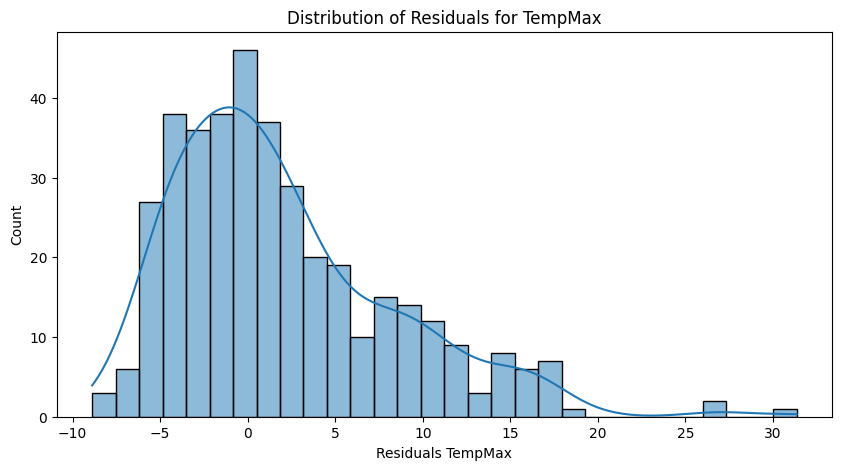

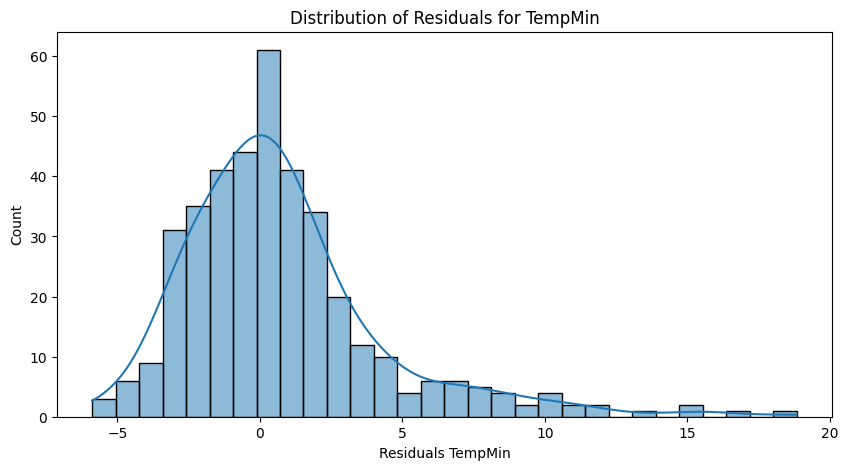

In [16]:
import seaborn as sns

# Plot distribution of residuals for TempMax
plt.figure(figsize=(10, 5))
sns.histplot(residuals_max, kde=True, bins=30)
plt.xlabel('Residuals TempMax')
plt.title('Distribution of Residuals for TempMax')
plt.show()

# Plot distribution of residuals for TempMin
plt.figure(figsize=(10, 5))
sns.histplot(residuals_min, kde=True, bins=30)
plt.xlabel('Residuals TempMin')
plt.title('Distribution of Residuals for TempMin')
plt.show()


### Autocorrelation

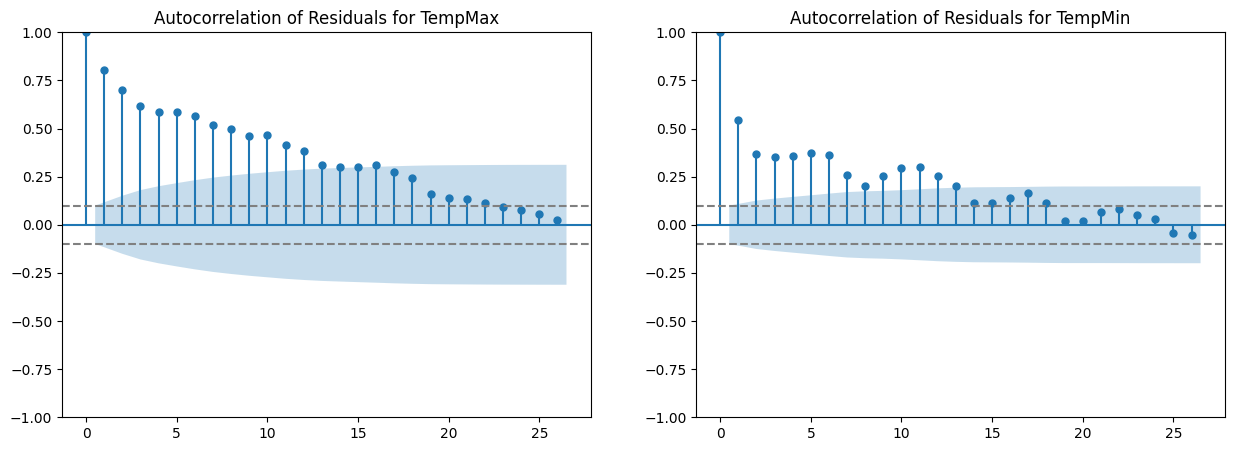

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fit the models using statsmodels for confidence interval calculations
X_train_max_sm = sm.add_constant(X_train_max)
X_val_max_sm = sm.add_constant(X_val_max)
X_train_min_sm = sm.add_constant(X_train_min)
X_val_min_sm = sm.add_constant(X_val_min)

model_max_sm = sm.OLS(y_train_max, X_train_max_sm).fit()
model_min_sm = sm.OLS(y_train_min, X_train_min_sm).fit()

# Get predictions and prediction intervals for the validation set
pred_max = model_max_sm.get_prediction(X_val_max_sm)
pred_min = model_min_sm.get_prediction(X_val_min_sm)

pred_max_summary = pred_max.summary_frame(alpha=0.05)
pred_min_summary = pred_min.summary_frame(alpha=0.05)

# Calculate the residuals
residuals_max = y_val_max - pred_max_summary['mean']
residuals_min = y_val_min - pred_min_summary['mean']

# Calculate the confidence interval for autocorrelation
n = len(residuals_max)
confidence_interval = 1.96 / np.sqrt(n)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot autocorrelation for TempMax residuals
plot_acf(residuals_max, ax=axes[0])
axes[0].set_title('Autocorrelation of Residuals for TempMax')

# Plot autocorrelation for TempMin residuals
plot_acf(residuals_min, ax=axes[1])
axes[1].set_title('Autocorrelation of Residuals for TempMin')

# Add confidence interval lines
for ax in axes:
    ax.axhline(y=confidence_interval, linestyle='--', color='gray')
    ax.axhline(y=-confidence_interval, linestyle='--', color='gray')

# Show the plots
plt.show()
